Classification Project 3
Kevin Andrews
March 1st, 2024

In [1]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import GridSearchCV
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.feature_selection import SelectKBest
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import FunctionTransformer
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt



In [2]:
# Load the data
dat = pd.read_csv('WI_breast_cancer.csv')

# Drop rows with missing values
dat_cleaned = dat.dropna().copy()

# Split data
train_set, test_set = train_test_split(dat_cleaned, test_size=0.2, random_state=42)

# Define features and labels
X_train = train_set.drop(["Class", "Id", "Unnamed: 0"], axis=1)
y_train = train_set["Class"]
X_test = test_set.drop(["Class", "Id", "Unnamed: 0"], axis=1)
y_test = test_set["Class"]

# Define categorical attributes
cat_attribs = list(X_train)
cat_attribs

['Cl.thickness',
 'Cell.size',
 'Cell.shape',
 'Marg.adhesion',
 'Epith.c.size',
 'Bare.nuclei',
 'Bl.cromatin',
 'Normal.nucleoli',
 'Mitoses']

I have loaded the data, then dropped any rows with missing data, then created the training and testing set. We have defined our attributes so we can access them and know which ones are of highest importance in predicting cancer

In [3]:
#creating the pipeline 
cat_pipeline = Pipeline([
    ('onehot', OneHotEncoder(handle_unknown='ignore')),
])

# Combine pipelines into a single preprocessing pipeline
preprocessing_pipeline = ColumnTransformer([
    ('cat', cat_pipeline, cat_attribs),
])



In [4]:
# to solve error
to_dense_transformer = FunctionTransformer(lambda x: x.toarray(), accept_sparse=True)


# Define the full pipeline
full_pipeline_grid_search_nb = Pipeline([
    ('preprocessing', preprocessing_pipeline),
    ('to_dense', to_dense_transformer),  # Convert sparse to dense
    ('feature_selection', SelectKBest()),
    ('model', GaussianNB()),
])

#parameters
param_grid_naive_bayes = {
    'feature_selection__k': list(range(1,9))  
}

# Set up GridSearchCV for Naive Bayes
grid_search_nb = GridSearchCV(full_pipeline_grid_search_nb, param_grid_naive_bayes,
                              cv=5, scoring='accuracy', return_train_score=True)

# Train the GridSearchCV model for Naive Bayes
grid_search_nb.fit(X_train, y_train)

# Get the best model for Naive Bayes
best_model_nb = grid_search_nb.best_estimator_

# Test the best Naive Bayes model
y_pred_grid_search_nb = best_model_nb.predict(X_test)

# Evaluate the best Naive Bayes model
accuracy_nb = accuracy_score(y_test, y_pred_grid_search_nb)
print('Naive Bayes Model Accuracy:', accuracy_nb)
print('Confusion Matrix for Naive Bayes:')
print(confusion_matrix(y_test, y_pred_grid_search_nb))

# Print the best parameters for Naive Bayes
print('Best Parameters for Naive Bayes:', grid_search_nb.best_params_)

Naive Bayes Model Accuracy: 0.9635036496350365
Confusion Matrix for Naive Bayes:
[[75  4]
 [ 1 57]]
Best Parameters for Naive Bayes: {'feature_selection__k': 8}


I remember you saying that Naive Bays is a good floor. The accuracy was fairly high, but less than logistic. It makes sense it is not perfect since the data in some of the variables is skewed and this model performs better with heavily clustered data that is normal. 

In [5]:
# Define the full pipeline
full_pipeline_logistic_regression = Pipeline([
    ('preprocessing', preprocessing_pipeline),
    ('model', LogisticRegression(random_state=42)),
])

# Train model
full_pipeline_logistic_regression.fit(X_train, y_train)

# Test model
y_pred_logistic_regression = full_pipeline_logistic_regression.predict(X_test)

# Evaluate the model 
accuracy = accuracy_score(y_test, y_pred_logistic_regression )
print('Accuracy:', accuracy)
print('Confusion Matrix:')
print(confusion_matrix(y_test, y_pred_logistic_regression ))


Accuracy: 0.9562043795620438
Confusion Matrix:
[[77  2]
 [ 4 54]]


This is just running a normal logistic regression and not adding parameters and using all the variables. I expected this to perform better than the naive bays but right now it is currently overfit. I am leaving the code to have something to compare to. 

In [6]:
#logistic reg grid

# Define the full pipeline
full_pipeline_grid_search = Pipeline([
    ('preprocessing', preprocessing_pipeline),
    ('feature_selection', SelectKBest()),
    ('model', LogisticRegression(random_state=42)),
])

# Define the parameterd
param_grid_logistic_regression = {
    'feature_selection__k': list(range(1,9))
    
}

# Set up GridSearchCV
grid_search = GridSearchCV(full_pipeline_grid_search, param_grid_logistic_regression,
                           cv=5, scoring='accuracy', return_train_score=True)

# Train the GridSearchCV model
grid_search.fit(X_train, y_train)

# Get the best model
best_model_log = grid_search.best_estimator_

# Test the best model
y_pred_grid_search = best_model_log.predict(X_test)

# Evaluate the best model
accuracy = accuracy_score(y_test, y_pred_grid_search)
print('Best Model Accuracy:', accuracy)
print('Confusion Matrix:')
print(confusion_matrix(y_test, y_pred_grid_search))

# You can also print the best parameters if you want
print('Best Parameters:', grid_search.best_params_)

Best Model Accuracy: 0.9781021897810219
Confusion Matrix:
[[78  1]
 [ 2 56]]
Best Parameters: {'feature_selection__k': 7}


This performed better when using less variables. The 97.8% accuracy and the low false positives and true negatives are a great sign. So far this is the best model. 

In [7]:

transformed_feature_names = preprocessing_pipeline.named_transformers_['cat'].named_steps['onehot'].get_feature_names_out(cat_attribs)

# Get the mask of selected features
selected_mask = best_model_log.named_steps['feature_selection'].get_support()
# Apply mask to the transformed feature names to get only the selected feature names
selected_feature_names = transformed_feature_names[selected_mask]

# Get the coefficients from the logistic regression model
coefficients = best_model_log.named_steps['model'].coef_[0]

# Create a DataFrame to display feature names and their corresponding coefficients
feature_weights = pd.DataFrame({
    'Feature': selected_feature_names,
    'Coefficient': coefficients
})

print(feature_weights)



             Feature  Coefficient
0        Cell.size_1    -1.510635
1       Cell.shape_1    -1.311040
2    Marg.adhesion_1    -0.970062
3     Epith.c.size_2    -1.438672
4    Bare.nuclei_1.0    -1.818578
5   Bare.nuclei_10.0     1.914942
6  Normal.nucleoli_1    -1.068889


In [8]:
# Define the full pipeline 
full_pipeline_svm = Pipeline([
    ('preprocessing', preprocessing_pipeline),
    ('feature_selection', SelectKBest(k=7)),  
    ('model', SVC(kernel='poly', degree=1, C=.1, max_iter=10000, random_state=42)),
])

# Train the model
full_pipeline_svm.fit(X_train, y_train)

# Predict using the trained model
y_pred_svm = full_pipeline_svm.predict(X_test)

# Evaluate the model
accuracy_svm = accuracy_score(y_test, y_pred_svm)
print('Model Accuracy:', accuracy_svm)
print('Confusion Matrix:')
print(confusion_matrix(y_test, y_pred_svm))


Model Accuracy: 0.9708029197080292
Confusion Matrix:
[[77  2]
 [ 2 56]]


I experimented with the number of features and found that using 7 gave the highest accuracy. I also manipulated the number of degrees and 3 was fairly accurate but when I changed other parameters I found that using a linear line was sometimes better. I found using these parameters listed above gave fairly accurate testing results. In the next coding cell I will use cross validation and grid search to find the best parameter. 

In [9]:
# Define the full pipeline 
full_pipeline_svm_grid = Pipeline([
    ('preprocessing', preprocessing_pipeline),
    ('feature_selection', SelectKBest()),  
    ('model', SVC(random_state=42, max_iter=10000)),
])

# Define the parameter grid to search
param_svm_grid = {
    'feature_selection__k': list(range(1,9)),  # Example values
    'model__C': [0.01, .1, 1, 10, 100],
    'model__kernel': ['poly'],
    'model__degree': [1,3,5,7,9],
}


# Set up the GridSearchCV object
grid_search = GridSearchCV(full_pipeline_svm_grid, param_svm_grid, cv=5, scoring='accuracy', verbose=1)

# Fit the GridSearchCV object to find the best model
grid_search.fit(X_train, y_train)

# Print the best parameters and the best score
print("Best parameters found: ", grid_search.best_params_)
print("Best cross-validation score (accuracy): {:.3f}".format(grid_search.best_score_))

# Predict using the best model
best_model = grid_search.best_estimator_
y_pred_svm = best_model.predict(X_test)

# Evaluate the best model
accuracy_svm = accuracy_score(y_test, y_pred_svm)
print('Model Accuracy:', accuracy_svm)
print('Confusion Matrix:')
print(confusion_matrix(y_test, y_pred_svm))

Fitting 5 folds for each of 200 candidates, totalling 1000 fits
Best parameters found:  {'feature_selection__k': 8, 'model__C': 0.01, 'model__degree': 1, 'model__kernel': 'poly'}
Best cross-validation score (accuracy): 0.954
Model Accuracy: 0.9635036496350365
Confusion Matrix:
[[74  5]
 [ 0 58]]


It didn't do any better than when I manually imputed the parameters unless we care about reducing the false positive. I am not surprised this didn't perform incredibly well since it seems like drawing a line through the data trying to maximize the margins for this data would not be that accurate since the data is messy.

In [10]:
# KNeighborsClassifier 

# Define the full pipeline for KNN
full_pipeline_knn_grid = Pipeline([
    ('preprocessing', preprocessing_pipeline),
    ('feature_selection', SelectKBest()),  
    ('model', KNeighborsClassifier()),
])

# Define the parameter grid to search for KNN
param_knn_grid = {
    'feature_selection__k': list(range(1, 9)),  
    'model__n_neighbors': [3, 5, 7, 9, 11],  
}

# Set up the GridSearchCV object for KNN
grid_search_knn = GridSearchCV(full_pipeline_knn_grid, param_knn_grid, cv=5, scoring='accuracy', verbose=1)

# Fit the GridSearchCV object to find the best KNN model
grid_search_knn.fit(X_train, y_train)

# Print the best parameters and the best score for KNN
print("Best parameters found for KNN: ", grid_search_knn.best_params_)
print("Best cross-validation score (accuracy) for KNN: {:.3f}".format(grid_search_knn.best_score_))

# Predict using the best KNN model
best_model_knn = grid_search_knn.best_estimator_
y_pred_knn = best_model_knn.predict(X_test)

# Evaluate the best KNN model
accuracy_knn = accuracy_score(y_test, y_pred_knn)
print('KNN Model Accuracy:', accuracy_knn)
print('Confusion Matrix for KNN:')
print(confusion_matrix(y_test, y_pred_knn))

Fitting 5 folds for each of 40 candidates, totalling 200 fits
Best parameters found for KNN:  {'feature_selection__k': 8, 'model__n_neighbors': 7}
Best cross-validation score (accuracy) for KNN: 0.943
KNN Model Accuracy: 0.9708029197080292
Confusion Matrix for KNN:
[[77  2]
 [ 2 56]]


K-nearest neighbors sounded like a great model since I feel like there is a very high chance data next to each other behave similarly and will be benign and malignant at the same rate. This was fairly true and the model performed very well. I expect decision trees to perform even better. 

In [11]:
full_pipeline_dt_grid = Pipeline([
    ('preprocessing', preprocessing_pipeline),
    ('feature_selection', SelectKBest()),  
    ('model', DecisionTreeClassifier(random_state=42)),
])

# Define the parameter grid to search for Decision Trees
param_dt_grid = {
    'feature_selection__k': list(range(1, 9)),  
    'model__max_depth': [ 5, 10, 15,20],  
    'model__min_samples_split': [2, 3, 5, 10],  # Example values for min samples to split
    'model__min_samples_leaf': [1, 2, 4, 8],  # Example values for min samples in a leaf
}

# Set up the GridSearchCV object for Decision Trees
grid_search_dt = GridSearchCV(full_pipeline_dt_grid, param_dt_grid, cv=5, scoring='accuracy', verbose=1)

# Fit the GridSearchCV object to find the best Decision Tree model
grid_search_dt.fit(X_train, y_train)

# Print the best parameters and the best score for Decision Trees
print("Best parameters found for Decision Tree: ", grid_search_dt.best_params_)
print("Best cross-validation score (accuracy) for Decision Tree: {:.3f}".format(grid_search_dt.best_score_))

# Predict using the best Decision Tree model
best_model_dt = grid_search_dt.best_estimator_
y_pred_dt = best_model_dt.predict(X_test)

# Evaluate the best Decision Tree model
accuracy_dt = accuracy_score(y_test, y_pred_dt)
print('Decision Tree Model Accuracy:', accuracy_dt)
print('Confusion Matrix for Decision Tree:')
print(confusion_matrix(y_test, y_pred_dt))

Fitting 5 folds for each of 512 candidates, totalling 2560 fits
Best parameters found for Decision Tree:  {'feature_selection__k': 8, 'model__max_depth': 10, 'model__min_samples_leaf': 2, 'model__min_samples_split': 2}
Best cross-validation score (accuracy) for Decision Tree: 0.941
Decision Tree Model Accuracy: 0.9708029197080292
Confusion Matrix for Decision Tree:
[[78  1]
 [ 3 55]]


This code took a lot longer to run which is obviously expected but it didn't perform any more accurate. I expected decision tree to be the best test so far, since decision trees are great at capturing non-linear relationships. I tried to give a wide range of depth and min for continual split and making decisions. These results are still quite high but with more data this may not be the best method especially with all the grid searching I was performing. I expect random forests to perform better than the decision tree. 

In [12]:
# Define the full pipeline for Random Forests
full_pipeline_rf_grid = Pipeline([
    ('preprocessing', preprocessing_pipeline),
    ('feature_selection', SelectKBest()),  
    ('model', RandomForestClassifier(random_state=42)),
])

# Define the parameter grid to search for Random Forests
param_rf_grid = {
    'feature_selection__k': list(range(1, 9)),  
    'model__max_depth': [5, 10, 15],  
    'model__min_samples_split': [2, 3, 5],  
    'model__min_samples_leaf': [1, 2, 4],  
    'model__n_estimators': [100, 200, 300],  # Number of trees in the forest
}

# Set up the GridSearchCV object for Random Forests
grid_search_rf = GridSearchCV(full_pipeline_rf_grid, param_rf_grid, cv=5, scoring='accuracy', verbose=1)

# Fit the GridSearchCV object to find the best Random Forest model
grid_search_rf.fit(X_train, y_train)

# Print the best parameters and the best score for Random Forests
print("Best parameters found for Random Forest: ", grid_search_rf.best_params_)
print("Best cross-validation score (accuracy) for Random Forest: {:.3f}".format(grid_search_rf.best_score_))

# Predict using the best Random Forest model
best_model_rf_compare = grid_search_rf.best_estimator_
y_pred_rf = best_model_rf_compare.predict(X_test)

# Evaluate the best Random Forest model
accuracy_rf = accuracy_score(y_test, y_pred_rf)
print('Random Forest Model Accuracy:', accuracy_rf)
print('Confusion Matrix for Random Forest:')
print(confusion_matrix(y_test, y_pred_rf))

Fitting 5 folds for each of 648 candidates, totalling 3240 fits
Best parameters found for Random Forest:  {'feature_selection__k': 7, 'model__max_depth': 5, 'model__min_samples_leaf': 4, 'model__min_samples_split': 2, 'model__n_estimators': 300}
Best cross-validation score (accuracy) for Random Forest: 0.947
Random Forest Model Accuracy: 0.9781021897810219
Confusion Matrix for Random Forest:
[[78  1]
 [ 2 56]]


This code took forever but the fact that it chose the max number of random forest models and min for leafs I want to increase these amount. I will run a separate code, since the code takes forever to run and I want to be better able to compare. 

In [13]:
# Define the full pipeline for Random Forests 
full_pipeline_rf_grid_2 = Pipeline([
    ('preprocessing', preprocessing_pipeline),
    ('feature_selection', SelectKBest(k=7)),  
    ('model', RandomForestClassifier(random_state=42)),
])

# Define the parameter grid to search for Random Forests
param_rf_grid_2 = {
    'model__max_depth': [1, 2, 5, 10, 15],  
    'model__min_samples_split': [2, 3],  
    'model__min_samples_leaf': [2, 4, 8],  
    'model__max_leaf_nodes': [3, 5, 10, 20],
    'model__n_estimators': [300, 400, 500],  # Number of trees in the forest
}

# Set up the GridSearchCV object for Random Forests
grid_search_rf = GridSearchCV(full_pipeline_rf_grid_2, param_rf_grid_2, cv=5, scoring='accuracy', verbose=1)

# Fit the GridSearchCV object to find the best Random Forest model
grid_search_rf.fit(X_train, y_train)

# Print the best parameters and the best score for Random Forests
print("Best parameters found for Random Forest: ", grid_search_rf.best_params_)
print("Best cross-validation score (accuracy) for Random Forest: {:.3f}".format(grid_search_rf.best_score_))

# Predict using the best Random Forest model
best_model_rf = grid_search_rf.best_estimator_
y_pred_rf = best_model_rf.predict(X_test)

# Evaluate the best Random Forest model
accuracy_rf = accuracy_score(y_test, y_pred_rf)
print('Random Forest Model Accuracy:', accuracy_rf)
print('Confusion Matrix for Random Forest:')
print(confusion_matrix(y_test, y_pred_rf))

Fitting 5 folds for each of 360 candidates, totalling 1800 fits
Best parameters found for Random Forest:  {'model__max_depth': 5, 'model__max_leaf_nodes': 10, 'model__min_samples_leaf': 4, 'model__min_samples_split': 2, 'model__n_estimators': 500}
Best cross-validation score (accuracy) for Random Forest: 0.947
Random Forest Model Accuracy: 0.9781021897810219
Confusion Matrix for Random Forest:
[[78  1]
 [ 2 56]]


I used 7 for my feature selection since the last decision tree and my logistic regression used 7. In the first project I also found 7 variables were best since cell.size and cell shape were very correlated and mitoses was not very correlated with class. I could have gotten rid of these two probably from the start, but decided to keep them in case I was missing something. I decided to set 300 as the low end for the number of trees in the forest since 300 was the highest last time. I wanted to add a new feature of max leaf nodes to maybe limit the complexity of the model. In the end it performed the same. I will go forward using the previous random forest since it's complexity is a little lower with the 300 trees vs 500. 

Now I will compare the soft classification of the models. I will only compare logistic regression model and the random forest. 
I want to know which model is making classifications off higher confidence or probability. 

Average prediction confidence for Logistic Regression: 0.9297
Average prediction confidence for Random Forest: 0.9151


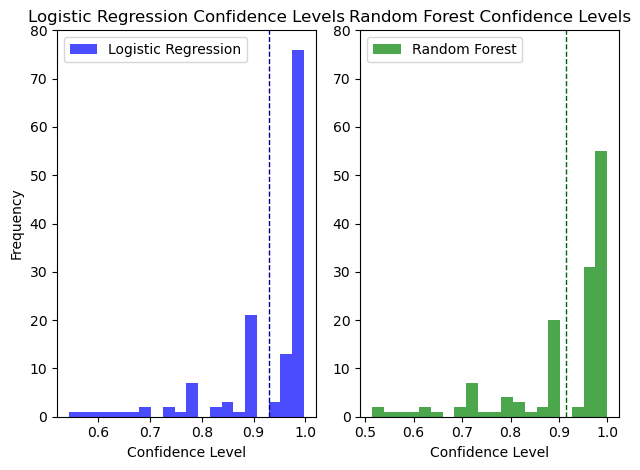

In [14]:
# Logistic Regression: Get the prediction probabilities
log_probs = best_model_log.predict_proba(X_test)
# Take the max probability for each prediction to represent confidence
log_confidences = log_probs.max(axis=1)
# Calculate the average confidence across all predictions
avg_confidence_log = log_confidences.mean()

# Random Forest: Get the prediction probabilities
rf_probs = best_model_rf_compare.predict_proba(X_test)
# Take the max probability for each prediction to represent confidence
rf_confidences = rf_probs.max(axis=1)
# Calculate the average confidence across all predictions
avg_confidence_rf = rf_confidences.mean()

print(f'Average prediction confidence for Logistic Regression: {avg_confidence_log:.4f}')
print(f'Average prediction confidence for Random Forest: {avg_confidence_rf:.4f}')
# Histogram for Logistic Regression confidence levels
plt.subplot(1, 2, 1)
plt.hist(log_confidences, bins=20, color='blue', alpha=0.7, label='Logistic Regression')
plt.axvline(avg_confidence_log, color='darkblue', linestyle='dashed', linewidth=1)
plt.title('Logistic Regression Confidence Levels')
plt.xlabel('Confidence Level')
plt.ylabel('Frequency')
plt.ylim(0, 80)
plt.legend()

# Histogram for Random Forest confidence levels
plt.subplot(1, 2, 2)
plt.hist(rf_confidences, bins=20, color='green', alpha=0.7, label='Random Forest')
plt.axvline(avg_confidence_rf, color='darkgreen', linestyle='dashed', linewidth=1)
plt.title('Random Forest Confidence Levels')
plt.ylim(0, 80)
plt.xlabel('Confidence Level')
plt.legend()

plt.tight_layout()
plt.show()

After looking at these results we see that logistic regression is the best option. The confusion matrices are the same and the accuracy is also the same. But the prediction confidence is almost 1.5% higher. Logistic regression also offers some extra benefits of being a less complex. Looking at the charts we can see there are a significant high number of logistic regression confidence values of very close to 100%. There is also less closer to the 50% area, which at that point is not much better than a guess. 

In [15]:
#creating a useable model to predict


# Initialize an empty dictionary to store user input
patient_data = {}

for attrib in cat_attribs:
    while True:  # Start an infinite loop to keep asking for input until it's valid
        try:
            user_input = input(f"What is the patient's data for {attrib}? (Enter a number between 1 and 10) ")
            user_input = int(user_input)  # Convert input to integer for comparison
            if 1 <= user_input <= 10:  # Check if input is within the desired range
                patient_data[attrib] = [user_input]  # If valid, add it to the dictionary
                break  # Break the loop to move to the next attribute
            else:
                print("Input is out of range. Please enter a number between 1 and 10.")
        except ValueError:  # Catch the exception if conversion to integer fails
            print("Invalid input. Please enter a numeric value between 1 and 10.")
            
# Convert the dictionary to a pandas DataFrame
patient_dataframe = pd.DataFrame.from_dict(patient_data)
print(patient_dataframe.to_string())

# Predict the probability of each class
probs = best_model_log.predict_proba(patient_dataframe)

prob_class_0 = probs[0][0]  # Probability of the sample being in class 0
prob_class_1 = probs[0][1]  # Probability of the sample being in class 1

if prob_class_0 > 0.5:
    # The model is more confident that the sample belongs to the positive class
    print(f"The patient has a benign tumor with a confidence level of: {prob_class_0:.2f}")
else:
    # The model is more confident that the sample belongs to the negative class
    print(f"The patient has a malignant tumor with a confidence level of: {prob_class_1:.2f}")

print("From the results on testing our model there is a 1.75% probability of a false positive and a 2.5% of a false negative." )


   Cl.thickness  Cell.size  Cell.shape  Marg.adhesion  Epith.c.size  Bare.nuclei  Bl.cromatin  Normal.nucleoli  Mitoses
0             2          1           2              4             5            3            2                4        1
The patient has a malignant tumor with a confidence level of: 0.67
From the results on testing our model there is a 1.75% probability of a false positive and a 2.5% of a false negative.
